In [7]:
import pandas as pd
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [8]:
import seaborn as sns

In [9]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [10]:
my_session.connection.schema

'CPG_BRONZE'

In [11]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [12]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [13]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [17]:
df=sf_df.to_pandas()

In [18]:
df.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202401,2024-01-18,2024-01-02,1537.89,16,0.001712,1585.454545,202201,DB0706,OL144111,Sedalia,Missouri,City Center,Str4,PRD0064,Hair Care,Conditioner,Bamboo
1,202401,2024-01-28,2024-01-02,518.18,3,0.001125,518.181818,202201,DB0706,OL238706,Williston,North Dakota,City Center,Str1,PRD0113,Perfume and Deodrants,Unisex Deodrant,Navy Blue
2,202401,2024-01-13,2024-01-02,113.64,1,0.000250,113.636364,202201,DB0706,OL223076,Silver City,New Mexico,Santa Cruz,Str1,PRD0107,Lotion,Body Lotion,Coral
3,202401,2024-01-06,2024-01-02,285.71,32,0.000832,285.714286,202201,DB0652,OL175529,Dunkirk,New York,Dolphin,Str3,PRD0147,Kids Care,Baby Cream,Mint
4,202401,2024-01-18,2024-01-02,290.91,1,0.000500,290.909091,202201,DB0652,OL48851,Stroudsburg,Pennsylvania,City Center,Str2,PRD0004,Lotion,Body Lotion,Tan


In [20]:
df.shape

(966400, 18)

In [21]:
#How many % of missing values do we have for each feature?
missing_percentage = df.isnull().sum() / df.shape[0] * 100 
missing_percentage

MNTH_CODE           0.0
TRANS_DATE          0.0
START_DATE          0.0
SALES_VALUE         0.0
SALES_UNITS         0.0
SALES_VOLUME        0.0
SALES_PTR_VALUE     0.0
OC_CODE             0.0
DISTRIBUTOR_CODE    0.0
OUTLET_CODE         0.0
CITY                0.0
STATE               0.0
COUNTY              0.0
STREET              0.0
PRODUCT_CODE        0.0
CATEGORY            0.0
SUBCATEGORY         0.0
BRAND               0.0
dtype: float64

In [29]:
#no any transactions happened without distributer and no outliers/NULL in sales
df.loc[df.DISTRIBUTOR_CODE.isnull(), ["SALES_VOLUME", "SALES_UNITS"]].describe()

,SALES_VOLUME,SALES_UNITS
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [33]:
#no any transactions happened without distributer and no outliers in sales
df.loc[df.OUTLET_CODE.isnull(), ["SALES_VOLUME", "SALES_UNITS"]].describe()

,SALES_VOLUME,SALES_UNITS
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [35]:
df.OUTLET_CODE.nunique()

18833

In [36]:
df.DISTRIBUTOR_CODE.nunique()

5

In [38]:
#no negative sales happened
[df.describe()<0]

[       MNTH_CODE  SALES_VALUE  SALES_UNITS  SALES_VOLUME  SALES_PTR_VALUE  \
 count      False        False        False         False            False   
 mean       False        False        False         False            False   
 std        False        False        False         False            False   
 min        False        False        False         False            False   
 25%        False        False        False         False            False   
 50%        False        False        False         False            False   
 75%        False        False        False         False            False   
 max        False        False        False         False            False   
 
        OC_CODE  
 count    False  
 mean     False  
 std      False  
 min      False  
 25%      False  
 50%      False  
 75%      False  
 max      False  ]

In [43]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

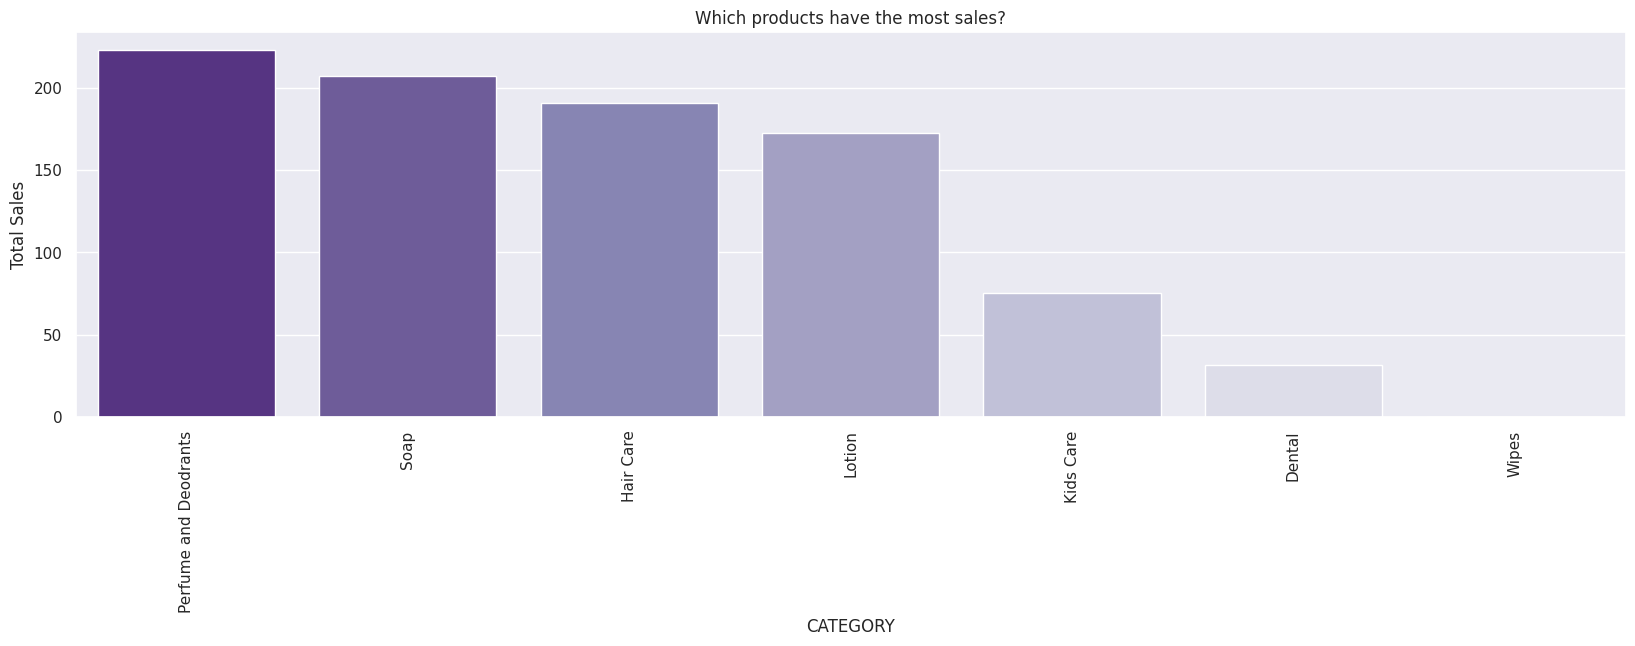

In [58]:

# Group by description and sum the sales
productby_sales = df.groupby('CATEGORY')['SALES_VOLUME'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=productby_sales.index, y=productby_sales.values, palette="Purples_r")
plt.ylabel("Total Sales")
plt.title("Which products have the most sales?")
plt.xticks(rotation=90)
plt.show()


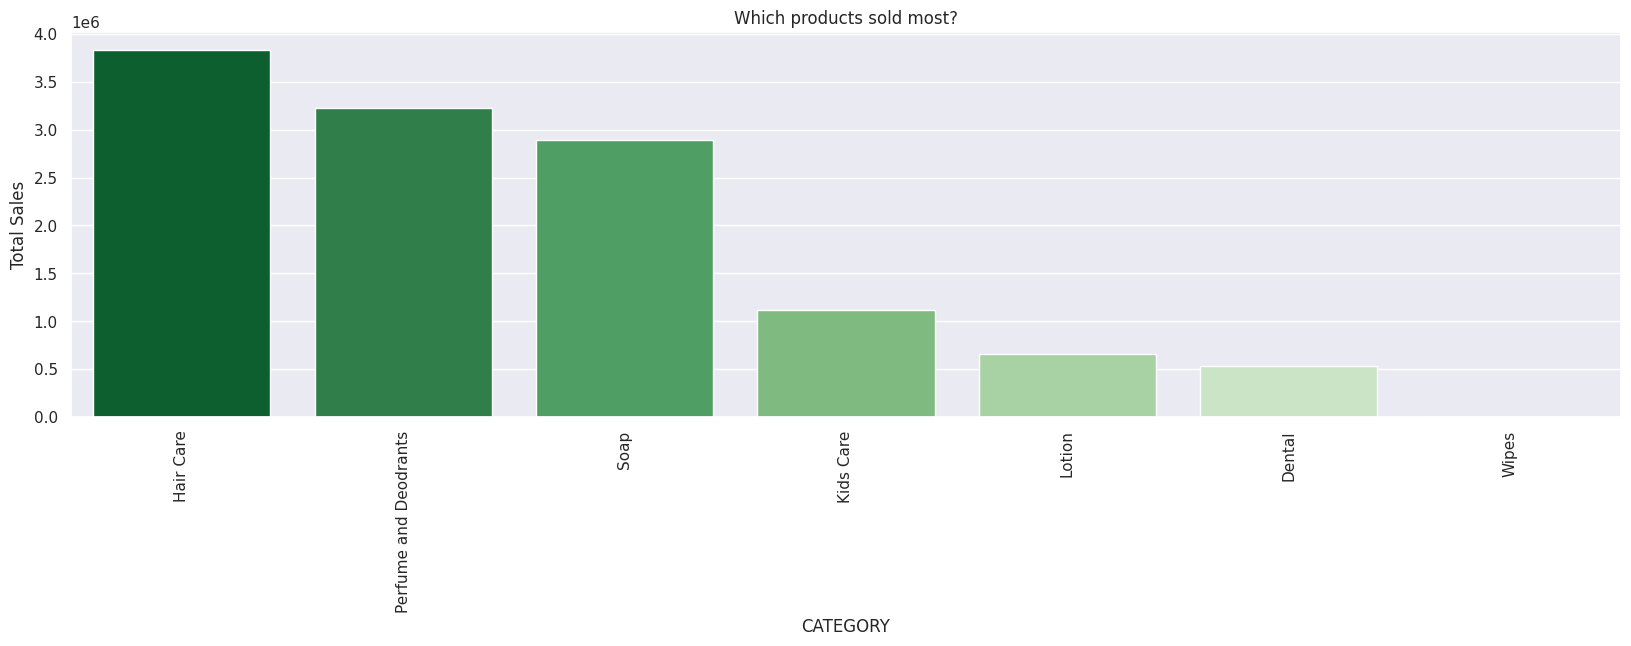

In [68]:

# Group by description and sum the sales
productby_qty = df.groupby('CATEGORY')['SALES_UNITS'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=productby_qty.index, y=productby_qty.values, palette="Greens_r")
plt.ylabel("Total Sales")
plt.title("Which products sold most?")
plt.xticks(rotation=90)
plt.show()


In [62]:
df.COUNTY.nunique()

9

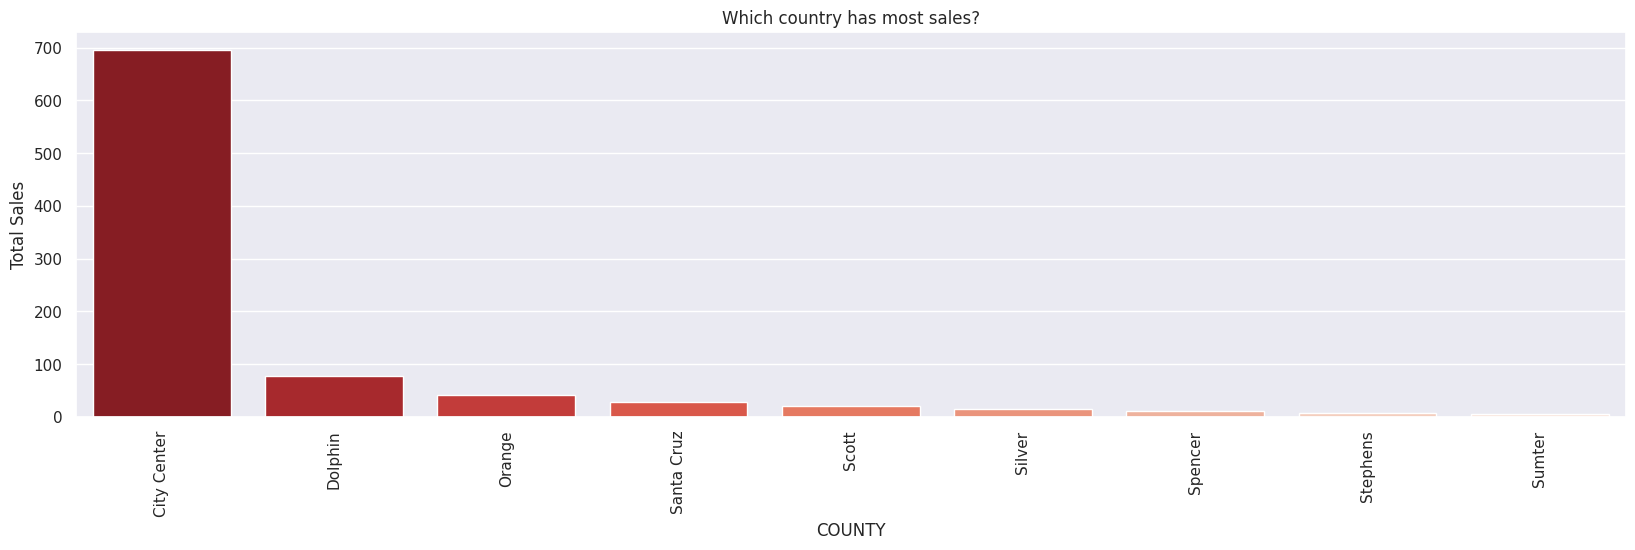

In [69]:

# Group by description and sum the sales
country_sales = df.groupby('COUNTY')['SALES_VOLUME'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=country_sales.index, y=country_sales.values, palette="Reds_r")
plt.ylabel("Total Sales")
plt.title("Which country has most sales?")
plt.xticks(rotation=90)
plt.show()


In [ ]:

data.loc[data.Country=="CIty Center"] 
# Group by description and sum the sales
country_sales = df.groupby('COUNTY')['CATEGORY'].sum().sort_values(ascending=False).iloc[0:30]

# Plotting
plt.figure(figsize=(20, 5))
sns.barplot(x=country_sales.index, y=country_sales.values, palette="Reds_r")
plt.ylabel("Total Sales")
plt.title("Which product sold most in city center?")
plt.xticks(rotation=90)
plt.show()